# Machine Learning: Vorhersage von Hauspreisen

Hier werden verschiedene Modelle ausprobiert und analysiert.

In [1]:
# Initialisierung
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
df = pd.read_csv ('../dataset/train.csv', index_col='Id')

## Random Forest

Da es in der Datei schon mehrere Attributen gibt und es nicht sicher ist, welche Attributen auf den Verkaufspreis einen Einfluss haben, wird nun zuerst Random Forest durchgeführt, um den relevanten Attributen herauszufinden.

Weil der Random Forest-Algorithmus nur numerische Daten verarbeiten kann, wandeln wir zuerst mithilfe von OneHotEncoder alle kategorischen Variablen in numerische Werte um.

### Datensatz vorbereiten:

In [2]:
# Zeige, dass viele Spalten kategorische Variablen haben.
df.head()

,Wohngebiet,Nachbarschaft,Bedingung1,Bedingung2,Wohnungsklasse,Gebauedetyp,Wohnungsstil,Baujahr,Umbaujahr,Hausqualitaet,...,Garagenqualitaet,Garagenzustand,EinfahrtGepflastert,Sondermerkmal,SondermerkmalWert,Verkaufsmonat,Verkaufsjahr,Verkaufstyp,Verkaufsbedingung,Verkaufspreis
Id,,,,,,,,,,,,,,,,,,,,,
1,WN,Gallus,Norm,Norm,20,1Fam,1Sto,1962,1962,3,...,Du,Ar,J,NaN,0.0,7,2019,GarK,Normal,69700.0
2,WN,Gallus,Norm,Norm,20,1Fam,1Sto,2015,2016,5,...,Du,Du,J,NaN,0.0,6,2017,GarK,Normal,133450.0
3,WN,Eckenhe,Norm,Norm,50,1Fam,2Sto,1930,1960,6,...,Du,Du,P,NaN,0.0,9,2016,GarK,Normal,165750.0
4,WN,Ginnhei,Norm,Norm,60,1Fam,2Sto,2009,2010,6,...,Du,Du,J,NaN,0.0,5,2017,GarK,Normal,157250.0
5,WN,Eckenhe,Norm,Norm,70,1Fam,2Sto,1939,1960,8,...,Du,Du,J,NaN,0.0,6,2016,GarK,Normal,195500.0


In [3]:
# kategorischen Variablen in numerische Werte umwandeln
categorical_columns = df.select_dtypes(include=['object']).columns
# encoder = OneHotEncoder(drop='first', sparse=False)
# df_encoded = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))
# encoded_columns = encoder.get_feature_names_out(categorical_columns)
# df_encoded.columns = encoded_columns
# df = pd.concat([df.drop(categorical_columns, axis=1), df_encoded], axis=1)

label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Speichere die Spaltennamen nach dem Label-Encoding
categorical_encoded_columns = [col for col in categorical_columns if col in df.columns]

# Zeige, dass alle Spalten nun numerische Werte besitzen
df.head()

,Wohngebiet,Nachbarschaft,Bedingung1,Bedingung2,Wohnungsklasse,Gebauedetyp,Wohnungsstil,Baujahr,Umbaujahr,Hausqualitaet,...,Garagenqualitaet,Garagenzustand,EinfahrtGepflastert,Sondermerkmal,SondermerkmalWert,Verkaufsmonat,Verkaufsjahr,Verkaufstyp,Verkaufsbedingung,Verkaufspreis
Id,,,,,,,,,,,,,,,,,,,,,
1,4,8,5,2,20,0,2,1962,1962,3,...,2,1,0,4,0.0,7,2019,2,3,69700.0
2,4,8,5,2,20,0,2,2015,2016,5,...,2,2,0,4,0.0,6,2017,2,3,133450.0
3,4,5,5,2,50,0,5,1930,1960,6,...,2,2,2,4,0.0,9,2016,2,3,165750.0
4,4,9,5,2,60,0,5,2009,2010,6,...,2,2,0,4,0.0,5,2017,2,3,157250.0
5,4,5,5,2,70,0,5,1939,1960,8,...,2,2,0,4,0.0,6,2016,2,3,195500.0


In [4]:
# Aber es ist noch problematisch, NaN-Werte zu haben.
df.isnull().sum()

Wohngebiet           0
Nachbarschaft        0
Bedingung1           0
Bedingung2           0
Wohnungsklasse       0
                    ..
Verkaufsmonat        0
Verkaufsjahr         0
Verkaufstyp          0
Verkaufsbedingung    0
Verkaufspreis        0
Length: 80, dtype: int64

In [5]:
# Fehlende Werte durch den Durchschnitt hinzufügen
df = df.fillna(df.mean())

# Nun gibt es keine NaN-Werte
df.isnull().sum()

Wohngebiet           0
Nachbarschaft        0
Bedingung1           0
Bedingung2           0
Wohnungsklasse       0
                    ..
Verkaufsmonat        0
Verkaufsjahr         0
Verkaufstyp          0
Verkaufsbedingung    0
Verkaufspreis        0
Length: 80, dtype: int64

### wichtige Merkmale zur Vorhersage herausfinden:

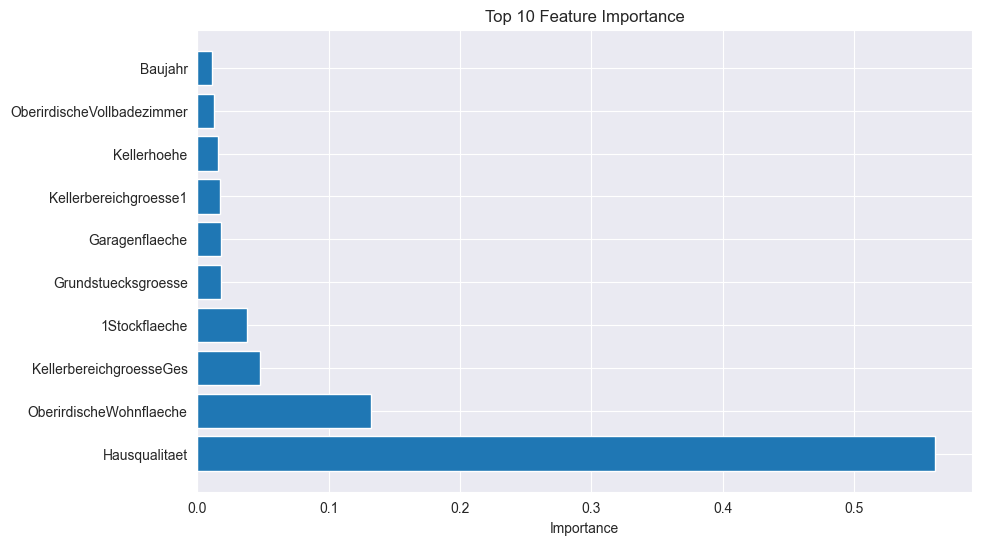

In [6]:
# Verkaufspreis ist die Zielvariable und die restliche Spalten sind potentielle relevante Attributen für die Vorhersage.
X = df.drop(['Verkaufspreis'], axis=1)
y = df['Verkaufspreis']

# Daten in Trainings- und Testsets aufteilen, dann Random Forest-Modell erstellen und trainieren
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
rf_model = RandomForestRegressor(random_state=123)
rf_model.fit(X_train, y_train)

# Feature Importance berechnen
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Feature Importance mittels Dataframe anzeigen
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.show()

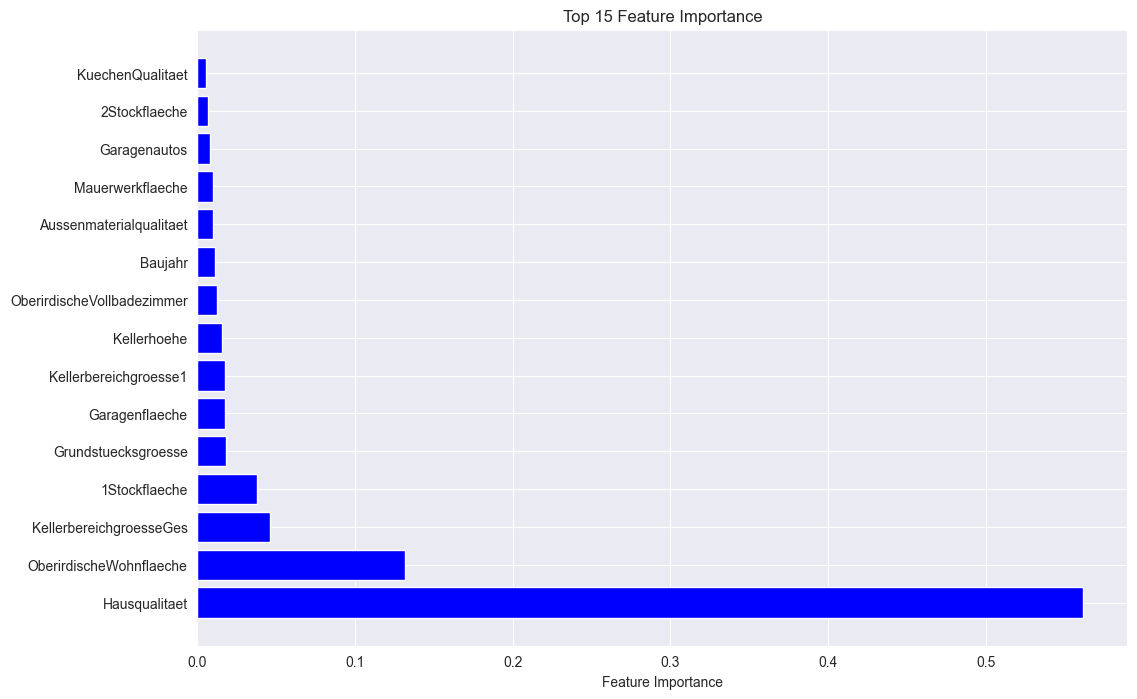

In [52]:
# Kumulative Feature Importance
feature_importance_df['Cumulative Importance'] = feature_importance_df['Importance'].cumsum()

# Plot der kumulativen Feature Importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15], color='b', align='center')
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance')
plt.show()

### Vorhersage erstellen:

In [80]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [82]:
# Vorhersagen für Trainingsdaten
y_train_pred = rf_model.predict(X_train)

# Vorhersagen für Testdaten
y_test_pred = rf_model.predict(X_test)

# Bewertung der Modellleistung auf Trainingsdaten
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
print(f'Trainings-MSE: {train_mse:.2f}')
print(f'Trainings-RMSE: {train_rmse:.2f}')
print(f'Trainings-R2: {r2_score(y_train,y_train_pred):.2f}')

# Bewertung der Modellleistung auf Testdaten
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print(f'Test-MSE: {test_mse:.2f}')
print(f'Test-RMSE: {test_rmse:.2f}')
print(f'Test-R2: {r2_score(y_test,y_test_pred):.2f}')

Trainings-MSE: 82617642.85
Trainings-RMSE: 9089.42
Trainings-R2: 0.98
Test-MSE: 637577797.62
Test-RMSE: 25250.30
Test-R2: 0.87


## GradientBoostingRegressor ausprobieren

Mithilfe von Feature Importance werden die wichtige Merkmale in anderen Modellen durchgeführt. Zum Beispiel mit GradientBoostingRegressor ist die Bewertung mit Top 10 ausgewählten Merkmalen am besten.

In [97]:
selected_features = feature_importance_df['Feature'][:10]

# Auswahl der relevanten Spalten
X_selected = df[selected_features]
y_selected = df['Verkaufspreis']

# Aufteilung in Trainings- und Testsets
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size=0.2, random_state=123)

# Wähle ein anderes Modell (Beispiel: Gradient Boosting Regressor)
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=123)
gb_model.fit(X_train_selected, y_train_selected)

# Vorhersagen für Trainingsdaten
y_train_pred_gb = gb_model.predict(X_train_selected)

# Vorhersagen für Testdaten
y_test_pred_gb = gb_model.predict(X_test_selected)

# Bewertung der Modellleistung
train_mse_gb = mean_squared_error(y_train_selected, y_train_pred_gb)
train_rmse_gb = np.sqrt(train_mse_gb)
print(f'Trainings-MSE (Gradient Boosting): {train_mse_gb:.2f}')
print(f'Trainings-RMSE (Gradient Boosting): {train_rmse_gb:.2f}')
print(f'Trainings-R2: {r2_score(y_train_selected, y_train_pred_gb):.2f}')

test_mse_gb = mean_squared_error(y_test_selected, y_test_pred_gb)
test_rmse_gb = np.sqrt(test_mse_gb)
print(f'Test-MSE (Gradient Boosting): {test_mse_gb:.2f}')
print(f'Test-RMSE (Gradient Boosting): {test_rmse_gb:.2f}')
print(f'Test-R2: {r2_score(y_test_selected, y_test_pred_gb):.2f}')


Trainings-MSE (Gradient Boosting): 226517851.13
Trainings-RMSE (Gradient Boosting): 15050.51
Trainings-R2: 0.95
Test-MSE (Gradient Boosting): 412036588.53
Test-RMSE (Gradient Boosting): 20298.68
Test-R2: 0.92
